In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import ks_2samp

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

from models.gnn import Transformer, RegressionTransformer
from evaluation import *

from data import FixMoleculeDataset, get_hexane, get_gdb
from loss import smol_regression_l1, smol_score_l1

%matplotlib inline

In [2]:
# hyperparameters and dataset
batch_size = 1024
t_hat = 0.7

dataset_smiles = get_gdb()
dataset_plotter = MolPlotter(dataset_smiles)

In [3]:
# load models
score_model = Transformer()

score_run_name = 'trained'
model_path = 'models/trained/{model}_{run}/model/'

score_model.load_weights(model_path.format(model=score_model, run=score_run_name))
score_model.traineable = False

props_model = RegressionTransformer()

props_run_name = 'trained'
props_model.load_weights(model_path.format(model=props_model, run=props_run_name));
props_model.traineable = False

algo = SAnnealedLangevin(score_model)

In [4]:
# generate some random molecules
atoms, bonds = algo.generate_random(batch_size)

generated_smiles = postprocess(atoms, bonds)
generated_smiles = nuvfilter(generated_smiles, dataset_smiles)

nuv = len(generated_smiles) / batch_size
generated_plotter = MolPlotter(generated_smiles)

print(f'{len(generated_smiles)} novel and different molecules; nuv score of {nuv * 100:.2f}%')

100%|██████████| 50/50 [00:21<00:00,  2.34it/s]
132 novel and different molecules; nuv score of 12.89%


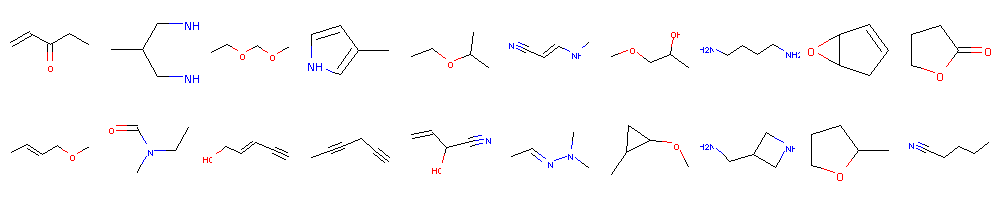

In [5]:
# plot dataset molecules (evaluate again for next molecules)
dataset_plotter(10, 2, 100)

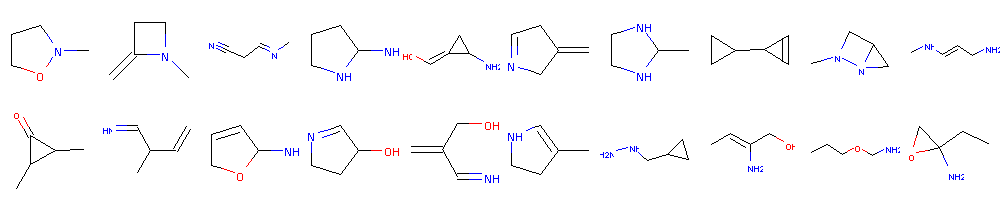

In [6]:
# plot generated molecules
generated_plotter(10, 2, 100)

In [7]:
# generate optimized molecules
def qed_sas_energy(atoms, bonds):
    props = props_model(atoms, bonds)
    qed, sas = props[:, 1], props[:, 2]
    return - 1.5 * qed + sas

opt_algo = SAnnealedLangevin(score_model, temp=0.56)
atoms, bonds = opt_algo.optimize_random(batch_size, qed_sas_energy, 30)

optimized_smiles = postprocess(atoms, bonds)
optimized_smiles = nuvfilter(optimized_smiles)

optimized_plotter = MolPlotter(optimized_smiles)

print(f'{len(optimized_smiles)} different molecules')

100%|██████████| 50/50 [00:59<00:00,  1.19s/it]
322 different molecules


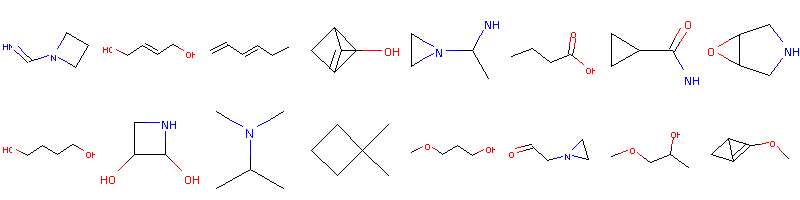

In [8]:
# plot generated, optimized molecules
optimized_plotter(8, 2, 100)

In [9]:
# check statistical significances (p <= 0.05)
dataset_props = get_properties(dataset_smiles)
optimized_props = get_properties(optimized_smiles)

dataset_qed = dataset_props['QED']
dataset_sas = dataset_props['SAS']

optimized_qed = optimized_props['QED']
optimized_sas = optimized_props['SAS']

qed_pvalue = ks_2samp(dataset_qed, optimized_qed, 'greater').pvalue
sas_pvalue = ks_2samp(dataset_sas, optimized_sas, 'less').pvalue

print(f'p-value for improved QED is {qed_pvalue:.3g} and {sas_pvalue:.3g} for -SAS')

p-value for improved QED is 9.07e-08 and 9.68e-21 for -SAS


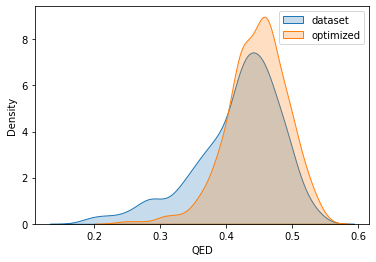

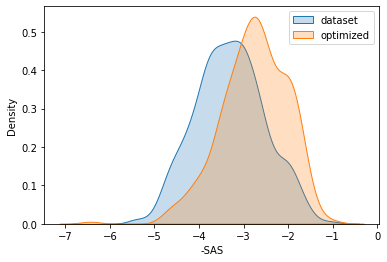

In [10]:
# plot general optimization results
sns.kdeplot(dataset_qed, label='dataset', fill=True)
sns.kdeplot(optimized_qed, label='optimized', fill=True)

plt.xlabel('QED')
plt.legend()
plt.show()

sns.kdeplot(-dataset_sas, label='dataset', fill=True)
sns.kdeplot(-optimized_sas, label='optimized', fill=True)

plt.xlabel('-SAS')
plt.legend();

100%|██████████| 50/50 [00:18<00:00,  2.71it/s]
316 different molecules


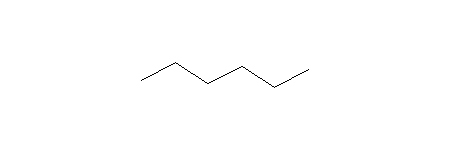

In [11]:
# edit hexane randomly
hexane_atoms, hexane_bonds, hexane_smiles = get_hexane(batch_size)

atoms, bonds = algo.edit_molecules(hexane_atoms, hexane_bonds, t_hat)

edited_smiles = postprocess(atoms, bonds)
edited_smiles = nuvfilter(edited_smiles)

edited_plotter = MolPlotter(edited_smiles)

print(f'{len(edited_smiles)} different molecules')

Chem.MolFromSmiles(hexane_smiles)

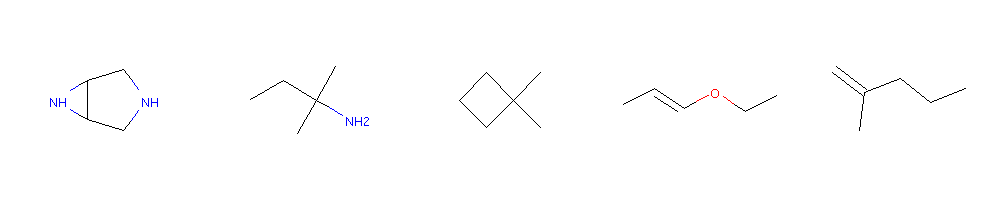

In [12]:
# plot editing results
edited_plotter(5, 1, 200)

In [13]:
# optimizing hexane's solubility in water
def solubility_energy(atoms, bonds):
    logp = props_model(atoms, bonds)[:, 0]
    return logp

atoms, bonds = algo.optimize_molecules(
    hexane_atoms, hexane_bonds, t_hat, solubility_energy, 15)

soluble_smiles = postprocess(atoms, bonds)
soluble_smiles = nuvfilter(soluble_smiles)

soluble_plotter = MolPlotter(edited_smiles)

print(f'{len(soluble_smiles)} different molecules')

100%|██████████| 50/50 [00:54<00:00,  1.08s/it]
516 different molecules


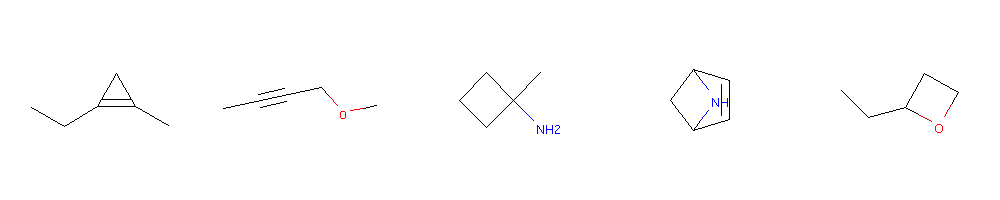

In [14]:
soluble_plotter(5, 1, 200)

p-value for improved logP is 1.34e-19


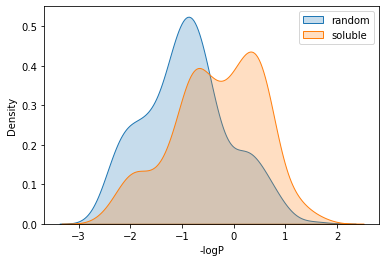

In [15]:
# plot solubility optimization results
edited_logp = get_properties(edited_smiles)['logP']
soluble_logp = get_properties(soluble_smiles)['logP']

logp_pvalue = ks_2samp(-edited_logp, -soluble_logp, 'greater').pvalue
print(f'p-value for improved logP is {logp_pvalue:.3g}')

sns.kdeplot(-edited_logp, label='random', fill=True)
sns.kdeplot(-soluble_logp, label='soluble', fill=True)

plt.xlabel('-logP')
plt.legend();

In [16]:
# check if models overfit
train_dataset = FixMoleculeDataset(6, supervised=True).get_split('train')
train_dataset = train_dataset.batch(1024)

atoms, bonds, props = next(iter(train_dataset))

train_score_loss = smol_score_l1(atoms, bonds, score_model)[0].numpy()
train_props_loss = smol_regression_l1(atoms, bonds, props, props_model)[0].numpy()

print('trainset:')
print(f'{train_score_loss:.2f} for the score model')
print(f'{train_props_loss:.2f} for the property model')

test_dataset = FixMoleculeDataset(6, supervised=True).get_split('train')
test_dataset = test_dataset.batch(1024)

atoms, bonds, props = next(iter(test_dataset))

test_score_loss = smol_score_l1(atoms, bonds, score_model)[0].numpy()
test_props_loss = smol_regression_l1(atoms, bonds, props, props_model)[0].numpy()

print('\ntestset:')
print(f'{test_score_loss:.2f} for the score model')
print(f'{test_props_loss:.2f} for the property model')

# calculate generalization delta
# less is better, below zero is possible because of randomness
score_delta = test_score_loss - train_score_loss
props_delta = test_props_loss - train_props_loss

print(f'\n{100 * score_delta / train_score_loss:.2f}% score delta')
print(f'{100 * props_delta / train_props_loss:.2f}% property delta')

trainset:
9.67 for the score model
0.36 for the property model

testset:
9.57 for the score model
0.38 for the property model

-1.06% score delta
4.89% property delta


In [17]:
# failure cases with very low -SAS

failure_smiles = []

failure_smiles += get_failures(generated_smiles)
failure_smiles += get_failures(edited_smiles)
failure_smiles += get_failures(soluble_smiles)
failure_smiles += get_failures(optimized_smiles)

failure_smiles = get_failures(failure_smiles) # for final sort
failure_plotter = MolPlotter(failure_smiles)

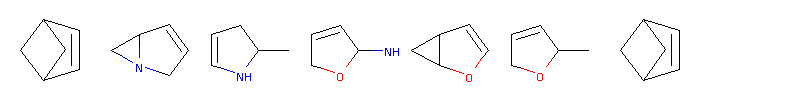

In [18]:
failure_plotter(8, 2, 100)